In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim


# First Approach: With mean and std

In [2]:
data_scene = pd.read_hdf('scene.hdf5')

# Extract images
scene_images = np.stack(data_scene['image'].values)
#calculating the mean

mean_image = np.mean(scene_images, axis=0)
#calculating the standard deviation
epsilon = 1e-8  # Small constant to prevent division by zero
std_image = np.std(scene_images, axis=0) + epsilon  


### Applying NUC

In [3]:
offset = mean_image
resp = std_image

corrected_images = np.array([(image - offset)/resp for image in scene_images])

### Displaying an example of corrected image

(-0.5, 639.5, 479.5, -0.5)

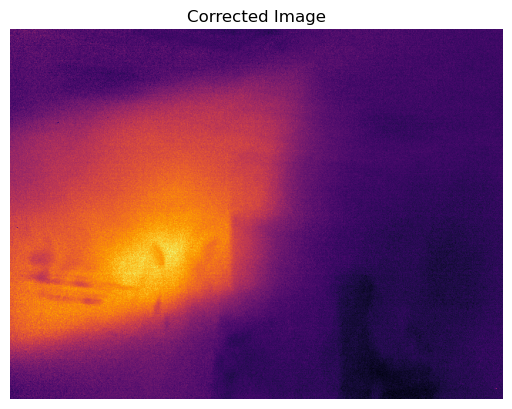

In [4]:
# corrected_images
plt.figure()
plt.imshow(corrected_images[59], cmap='inferno')
plt.title('Corrected Image')
plt.axis('off')

# Second Approach: using uniform image (selected image from scene.hdf5)

### Applied MSE and SSIM between mean image and all the images

In [5]:
# Extract images
scene_images = np.stack(data_scene['image'].values)

# Calculate the mean image
mean_image = np.mean(scene_images, axis=0)

'''

For selecting the offset image from the scene image data measuring the MSE and SSIM

'''

# Compute MSE for each image in scene_images using mean_squared_error from sklearn
mse_values = [mean_squared_error(mean_image.ravel(), img.ravel()) for img in scene_images]

# Get indices of the 10 images closest to the mean image by MSE
closest_images_indices_mse = sorted(range(len(mse_values)), key=lambda k: mse_values[k])[:10]

# Print indices of closest images of mean
print("Closest images by MSE:", closest_images_indices_mse)

#Calculate SSIM for each image
ssim_values = [ssim(mean_image, img, data_range=img.max() - img.min()) for img in scene_images]

# Find the indices of the top 10 images with highest SSIM to the mean image
closest_images_indices_ssim = sorted(range(len(ssim_values)), key=lambda k: ssim_values[k], reverse=True)[:10]

print("Closest images by SSIM:", closest_images_indices_ssim)

Closest images by MSE: [171, 172, 170, 40, 39, 41, 43, 42, 46, 47]
Closest images by SSIM: [172, 171, 42, 40, 170, 45, 47, 48, 43, 46]


### Applying NUC model

In [6]:
#Taking offset based on the image indices measured from MSE and SSIM
offset = scene_images[171]
responsivity = 1

# Correcting each scene image by applying NUC
corrected_images = np.array([(image - offset)/responsivity for image in scene_images])

### Displaying an example of corrected image

(-0.5, 639.5, 479.5, -0.5)

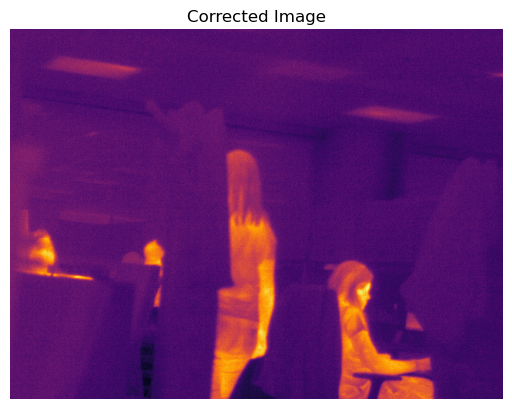

In [7]:
plt.figure()
plt.imshow(corrected_images[399], cmap='inferno')
plt.title('Corrected Image')
plt.axis('off')


### For sliding the Images 

In [8]:
from ipywidgets import interact, IntSlider

# Create an interactive widget to select and display images
def display_image(index):
    plt.imshow(corrected_images[index], cmap='gray')
    # plt.colorbar()
    plt.title(f'Log Transformed and Normalized Image {index}')
    plt.axis('off')
    plt.show()

interact(display_image, index=IntSlider(min=0, max=len(corrected_images)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

<function __main__.display_image(index)>

# For Merging into video

### In Gray Scale

In [7]:
import cv2
import numpy as np

print()
def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image) # finding the Nan values 
        mean_val = np.nanmean(image) # taking the mean of non-Nan vlaues
        image[nan_mask] = mean_val # replacing with the mean of non-Nan values
    return image

# new sequences by clearing the Nan values
corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]


def create_video_from_images(corrected_image_sequences_N, output_filename='task_3_S_1.avi', fps=40):

    # Normalize images based on global min and max
    global_min_n = min(image.min() for image in corrected_image_sequences_N)
    global_max_n = max(image.max() for image in corrected_image_sequences_N)
    corrected_image_sequences_N = [(255 * (image - global_min_n) / (global_max_n - global_min_n)).astype(np.uint8) for image in corrected_image_sequences_N]

    # Get the size of the images
    height, width = corrected_image_sequences_N[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=False)
    
    for image in corrected_image_sequences_N:
        out.write(image)
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)

#### In False Color

In [21]:
import cv2
import numpy as np

def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image)  # Finding the NaN values
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

corrected_image_sequences_N = [replace_nans(image) for image in corrected_images]

def create_video_from_images(images, output_filename='task_3_S_1_JET.avi', fps=40):
    images_colored = []
    for image in images:
        # Normalize the image
        min_val = image.min()
        max_val = image.max()
        if max_val > min_val:
            normalized_image = (image - min_val) / (max_val - min_val)
        else:  # Avoid division by zero if all values are the same
            normalized_image = np.zeros_like(image)

        normalized_image = (255 * normalized_image).astype(np.uint8)  # Scale to 255 and convert to uint8

        # Apply COLORMAP_JET to the normalized image
        colored_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)

        images_colored.append(colored_image)

    # Get the size of the images
    height, width = images_colored[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object with color
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=True)
    
    for image in images_colored:
        out.write(image)  # Write each frame to the video
    
    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)
